In [1]:
import pandas as pd
import string
import os
import numpy as np
from sqlalchemy import create_engine, text

from utils import DbEngine, Queries
from etl import ETL
from encoder import Encoding

In [2]:
import numpy as np
import sys

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score, fowlkes_mallows_score

from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

### Connect to DB

In [3]:
db_engine = DbEngine(user = 'team77', 
                     password = 'mintic2020.',
                     ip = '172.17.0.3', 
                     port = '5432', 
                     db = 'minjusticia')
engine = db_engine.connect()
queries = Queries(engine)

### Loading original data

In [3]:
data = pd.read_excel('../data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)

### Execute ETL

In [6]:
etl = ETL(queries)
etl.inmate_static_info(data)
etl.inmate_variable_info(data)

/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/etl.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['CONDIC_EXPECIONAL'] = data_reg['CONDIC_EXPECIONAL'].fillna('NINGUNO')
/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/etl.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['madre_gestante'] = 'NA'
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

### Encode

In [4]:
encoding = Encoding(queries)
data_2_encode = encoding.get_data()
data_encoded = encoding.one_hot(data_2_encode)
data_encoded

,internoen,genero,nacionalidad,reincidente,anio_nacimiento,estado_civil,nivel_educativo,reconocimiento_etnico,diversidad_sexual,extranjero,...,delito_id_delito_172,delito_id_delito_232,delito_id_delito_262,delito_id_delito_other,tentativa_1,tentativa_2,agravado_1,agravado_2,calificado_1,calificado_2
0,FD8EB8482F09C3F5FD085E4CAD29122368A5937B,2,22,2,1985,3,2,5,1,1,...,0,0,0,0,1,0,0,1,0,1
1,7624E0648E28D778D1EE4581998B00C3ABC061DA,2,22,2,1987,3,4,1,1,1,...,0,0,0,1,1,0,1,0,1,0
2,2660D0E0F43523200EF105604266F18D6CA396E5,2,22,2,1973,3,3,5,1,1,...,0,1,0,0,1,0,1,0,1,0
3,00CD632E133B134F4CD3659080F8E5E7C1C7330A,2,22,2,1970,3,3,5,1,1,...,0,0,1,0,1,0,1,0,1,0
4,7790E7531D616FDA7825C9CBB5502DD82DF35EB5,2,22,2,1988,1,5,5,1,1,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103285,C476DC9C78CBC61BC5A3D27699595E916D90E3E2,2,22,2,1985,6,2,5,1,1,...,0,1,0,0,1,0,1,0,1,0
103286,AEB9E4C6773CBBE7C8424A52AB686E9F14101E73,2,22,2,1985,7,10,5,1,1,...,0,0,0,1,1,0,1,0,1,0
103287,92FBC965E9DE8CE7CD6AF95F4C460AF9A788CF59,2,22,2,1999,6,4,5,1,1,...,0,0,0,0,1,0,0,1,0,1
103288,BE6DD3C2939188AAFE3CD16E971D7F6C2BCEBC73,2,22,2,1978,7,2,5,1,1,...,0,0,0,0,2,0,1,1,1,1


### Unsupervised Learning with Kmeans

#### Fixing dataset lasts issues

Evaluando cantidad de columnas vacias aún

In [5]:
data_encoded.isnull().sum().to_frame().rename(columns={0:'counts'}).sort_values(by='counts', ascending = False)

,counts
fecha_salida,30304
internoen,0
madre_gestante,0
discapacidad,0
adulto_mayor,0
delito_id_delito_42,0
delito_id_delito_102,0
delito_id_delito_103,0
delito_id_delito_105,0
delito_id_delito_109,0


Evaluando qué columnas colo tienen un valor, pues de deben eliminar para el modelin

In [6]:
data_encoded.nunique().sort_values()

situacion_juridica            1
reincidente                   1
municipio_id_municipio        1
estado_id_estado              2
hijos_menores                 2
actividades_enseñanza         2
actividades_trabajo           2
actividades_estudio           2
discapacidad                  2
adulto_mayor                  2
diversidad_sexual             2
genero                        2
extranjero                    2
madre_lactante                3
delito_id_delito_109          3
delito_id_delito_103          3
madre_gestante                3
delito_id_delito_172          3
delito_id_delito_262          4
delito_id_delito_42           4
delito_id_delito_102          4
delito_id_delito_105          5
reconocimiento_etnico         5
delito_id_delito_141          5
delito_id_delito_232          6
estado_ingreso                6
tentativa_2                   7
calificado_2                  7
delito_id_delito_145          8
estado_civil                  8
agravado_2                    8
delito_i

In [7]:
data_encoded['delito_id_delito_172'].unique()

array([0, 1, 2], dtype=uint8)

Eliminando columnas de fechas por ahora, id de inmate y columnas con menos de 2 variables únicas

In [8]:
data = data_encoded.drop(columns = ['internoen',
                                    'fecha_ingreso',
                                    'fecha_salida',
                                    'situacion_juridica',
                                    'reincidente',
                                    'municipio_id_municipio'])

Creando función para llevar a cabo un encoding nuevo, dado que aún hay variables no numéricas en los datos

In [9]:
def encode_transform(data):
    encoders = []
    encoded_cols = []
    for i in range(data.values.shape[1]):
        le = LabelEncoder()
        le.fit(data.values[:,i])
        encoders.append(le)
        encoded_cols.append(le.transform(data.values[:,i]).reshape(-1,1))
    return np.concatenate(encoded_cols, axis = 1), encoders

In [10]:
data_enc, encoders = encode_transform(data)
data_enc

array([[ 1, 21, 59, ...,  1,  0,  1],
       [ 1, 21, 61, ...,  0,  1,  0],
       [ 1, 21, 47, ...,  0,  1,  0],
       ...,
       [ 1, 21, 73, ...,  1,  0,  1],
       [ 1, 21, 52, ...,  1,  1,  1],
       [ 1, 21, 54, ...,  0,  1,  0]])

#### Elbow Plot (Within sum of squares distance)

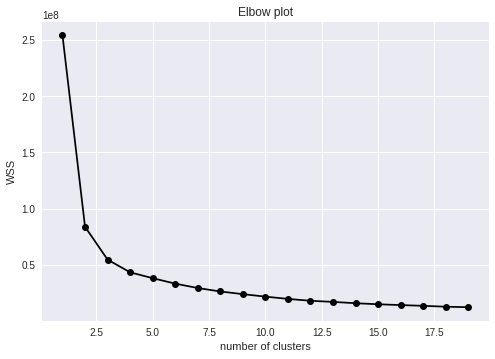

In [71]:
# setting the range of k
clusters = range(1, 20)

# running the clustering 
wss_list = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(data_enc)
    wss_list.append(model.inertia_)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

#### Prediction Strength

##### Data split

In [17]:
# train/test split
X_train, X_test = train_test_split(data_enc, 
                                   test_size=0.1, 
                                   shuffle=True, 
                                   random_state=42)

##### Get closest centroid unoptimized

In [12]:
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

##### Get closest centroid iptimized v1

In [13]:
def get_closest_centroid_optim(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance)
    
    return centroids[idx_min_distance]

##### Get closest centroid optimized v2

In [14]:
def get_closest_centroid_optim_vectorized(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance, axis = 0)
    
    return centroids[idx_min_distance]

##### Testing get_prediction_strength optimizations

In [360]:
model_train = KMeans(n_clusters=5, random_state=42).fit(X_train)
model_test = KMeans(n_clusters=5, random_state=42).fit(X_test)

In [361]:
X_test.shape, model_train.cluster_centers_.shape

((5165, 38), (5, 38))

In [362]:
closest_cent = get_closest_centroid_optim_vectorized(X_test, model_train.cluster_centers_)
closest_cent.shape

(5165, 38)

In [341]:
a = np.array([[1,2,3,4],
              [2,3,4,5],
              [1,2,3,4],
              [3,4,5,6]])
a

array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [1, 2, 3, 4],
       [3, 4, 5, 6]])

In [369]:
closest_cent.shape

(5165, 38)

In [363]:
%time
co_membership = np.zeros((len(closest_cent), len(closest_cent)))
for i in range(1,len(closest_cent)):
    diag = (closest_cent == np.roll(closest_cent, shift = i, axis = 0)).all(1)[i:]
    co_membership[range(i,len(closest_cent)),range(len(diag))] = diag
co_membership = co_membership + co_membership.T - np.diag(np.diag(co_membership))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.9 µs


In [364]:
x_test = X_test
test_labels = model_test.labels_

In [371]:
test_labels

array([3, 1, 0, ..., 2, 2, 1], dtype=int32)

In [373]:
np.roll(test_labels, shift = i)

array([1, 3, 1, ..., 4, 2, 2], dtype=int32)

In [374]:
test_labels == np.roll(test_labels, shift = i)

array([False, False, False, ..., False,  True, False])

In [382]:
test_labels == 4

1031

In [404]:
%time
test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
for i in range(len(test_labels)):
    diag = (test_labels == np.roll(test_labels, shift = i))# & (test_labels == 4)
    diag = diag[i:]
    test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 17.2 µs


In [392]:
b = np.array([4,4,1,1,1,4])
b

array([4, 4, 1, 1, 1, 4])

In [396]:
(b == np.roll(b, shift = 1)) & (b == 1)

array([False, False, False,  True,  True, False])

In [405]:
test_labels_co_mem[:15,:15]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 1., 0.

In [403]:
test_labels_co_mem[:15,:15]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [380]:
co_membership

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [409]:
k = 5

In [419]:
ss = []
for j in range(k):
    examples_j = x_test[test_labels == j, :].tolist()
    n_examples_j = len(examples_j)
    test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
    for i in range(len(test_labels)):
        diag = (test_labels == np.roll(test_labels, shift = i)) & (test_labels == j)
        diag = diag[i:]
        test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
    test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))
    s = (co_membership * test_labels_co_mem).sum()
    ss.append(s / (n_examples_j * (n_examples_j - 1))) 

In [421]:
min(ss)

0.9748147752606496

In [418]:
(n_examples_j * (n_examples_j - 1))

1061930

In [416]:
(co_membership * test_labels_co_mem).sum()

1051662.0

In [355]:
model_test.labels_.shape

(5165,)

##### Get prediction strength unoptimized

In [15]:
def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

##### Get prediction strength optimized

In [16]:
def get_prediction_strength_optim(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    closest_cent = get_closest_centroid_optim_vectorized(x_test, train_centroids)
    
    co_membership = np.zeros((len(closest_cent), len(closest_cent)))
    for i in range(len(closest_cent)):
        diag = (closest_cent == np.roll(closest_cent, shift = i, axis = 0)).all(1)[i:]
        co_membership[range(i,len(closest_cent)),range(len(diag))] = diag
    co_membership = co_membership + co_membership.T - np.diag(np.diag(co_membership))
    
    # calculate the prediction strengths for each cluster
    n_test = len(x_test)
    ss = []
    for j in range(k):
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
        for i in range(len(test_labels)):
            diag = (test_labels == np.roll(test_labels, shift = i)) & (test_labels == j)
            diag = diag[i:]
            test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
        test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))
        s = (co_membership * test_labels_co_mem).sum()
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

##### Running Optimized Implementation

In [18]:
# running the clustering 
strengths = []
clusters = range(2, 15)
for k in clusters:
    print(k)
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

2
3
4
5
6
7
8
9
10
11
12
13
14


2
3
4
5
6
7
8
9
10
11
12
13
14


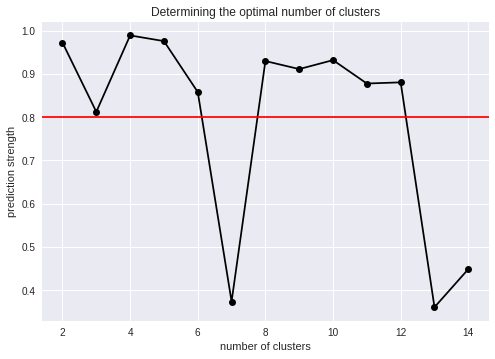

In [431]:
# plotting
### With 5% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

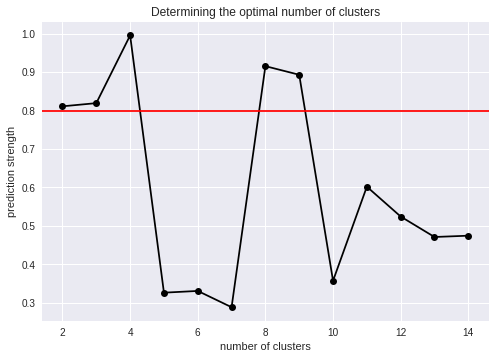

In [19]:
# plotting
### With 10% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

##### Reproducing article with optimized implementation

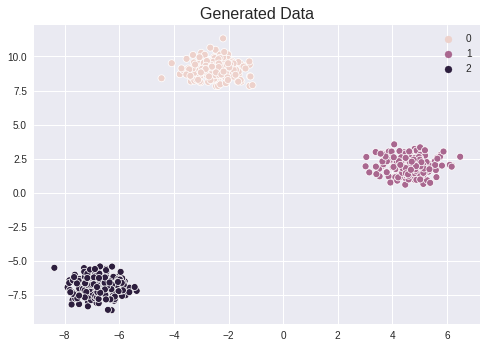

In [438]:
X, y = make_blobs(n_samples=600, centers=3, cluster_std=0.6, random_state=42)
ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
ax.set_title('Generated Data', fontsize=16);

In [439]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


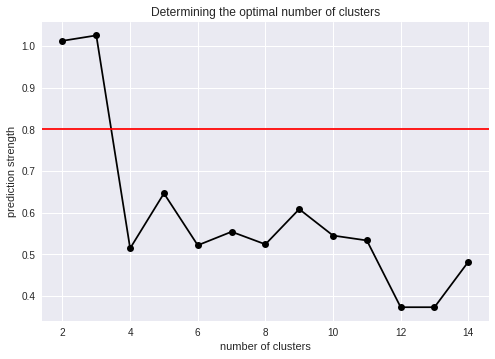

In [434]:
# running the clustering 
strengths = []
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

##### Reproducing article with unpptimized implementation

In [440]:
# running the clustering 
strengths = []
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

ZeroDivisionError: division by zero

#### Fowlkes Mallows Score

In [ ]:
# setting the range of k
clusters = range(2, 20)
k_fowlkes_mallows = []
for k in clusters:
    model = KMeans(n_clusters = k, n_init = 100, random_state = 0)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = fowlkes_mallows_score(data_enc, cluster)
    
    k_fowlkes_mallows.append(round(score,2))

In [ ]:
# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_fowlkes_mallows, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Calinski Harabaz Score

In [20]:
# setting the range of k
clusters = range(2, 20)
k_calinski_harabasz = []
for k in clusters:
    model = KMeans(n_clusters = k, random_state=42)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = calinski_harabasz_score(data_enc, cluster)
    
    k_calinski_harabasz.append(round(score,2))

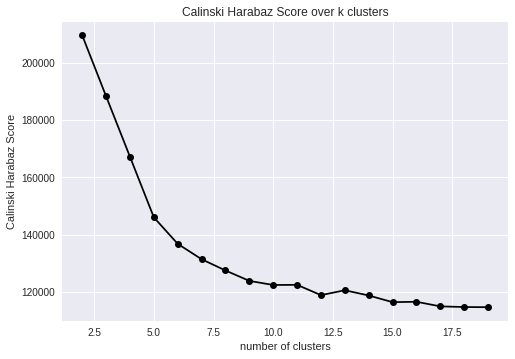

In [21]:
# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');